In [2]:
## import data processing/cleaning , data modeling libraries
import pandas as pd
import os
import sys
import re as re
import datetime as datetime
import numpy as np
import collections
import string
import pandas as pd

from nltk.tag.perceptron import PerceptronTagger
import nltk
from nltk.stem import WordNetLemmatizer,PorterStemmer
from nltk.corpus import stopwords

from gensim.models import Doc2Vec
#from gensim.models import Word2Vec
from gensim.models import fasttext

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.linear_model import SGDClassifier
from gensim.models.wrappers import FastText
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import classification_report

import warnings
warnings.filterwarnings('ignore')
t0 = datetime.datetime.now()

In [9]:
outData43 = pd.DataFrame()
limit = 20000

outData43_text = pd.read_csv("reviews.txt",encoding="utf-8",header=None,names=["text"])
outData43_lab = pd.read_csv("labels.txt",encoding="utf-8",header=None,names=["label"])
#outData43_text = outData43_text[:limit]
#outData43_lab = outData43_lab[:limit]
#outData43["length"]=outData43_text.text.apply(lambda x:len(x))
# print(outData43.head(n=2))

x_train,x_test,y_train,y_test = train_test_split(outData43_text,outData43_lab,test_size=0.4)

In [10]:
## NLP PRE-PROCESSING

#text=" the JanaSena Party Formation Day celebrations || LIVE funny celebration|| Pawan Kalyan || Guntur"
text="Chak De India | Full Title Song | Shah Rukh Khan | Sukhvinder Singh | Salim | Marianne D'Cruz"

def nltk_clean_sent(line):
    if len(line)>0:
        ## remove the punctuation/emoticons/digits/multispaces with single from the line
        ## dont make lowercase before the pos tagging
        line_lower = line.strip()
        line_punct = re.sub('['+string.punctuation+']',' ',line_lower)
        line_emots = re.sub(r'[\u200b-\u2fff]+',' ',line_punct)
        line_digis = re.sub(r'[0-9]+',' ',line_emots)
        line_spaces = re.sub(r'[\s]+',' ',line_digis)
        line = line_spaces
    return line.lower()

def nltk_extract_postags(tokens):
    cleaned_str = ''
    #tokens = nltk.word_tokenize(line)
    tokens_pos = PerceptronTagger().tag(tokens)
    #print(tokens_pos)
    # noun tags
    nn_tags = ['NN', 'NNP', 'NNP', 'NNPS', 'NNS']
    # adjectives
    jj_tags = ['JJ', 'JJR', 'JJS']
    # verbs
    vb_tags = ['VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ']
    nltk_tags = nn_tags + jj_tags + vb_tags
    
    for tag_word in tokens_pos:
#         if tag_word[1] in nltk_tags:
            if len(tag_word[0])>2:
                cleaned_str += tag_word[0].lower()+tag_word[1]+' '
    return cleaned_str.strip().split()

def nltk_apply_lemma(line):
    ## lemma is fine rather than stemming
    tokens_lemmas = [WordNetLemmatizer().lemmatize(word) for word in line.split()]
    #tokens_lemmas = [PorterStemmer().stem(word) for word in line.split()]
    ## stemming
    tokens_stops = [word for word in tokens_lemmas if word not in stopwords.words('english')]
    tokens_stops = [word for word in tokens_stops if len(word.strip())>2]
    tokens_stops = list(set(tokens_stops))
    return tokens_stops

def nltk_extract_tags(line):
        ## tokenize the sentence/get tokens that contains only letters
        line_clean = nltk_clean_sent(line)
        ## apply lemmatize/stemming and remove stopwords
        token_lemma = nltk_apply_lemma(line_clean)
#         apply postags to the words and get only couple of tags and word length >2
#         tokens_pos = nltk_extract_postags(token_lemma)
        
        return token_lemma
    
nltk_extract_tags(text)

['marianne',
 'khan',
 'singh',
 'salim',
 'rukh',
 'cruz',
 'sukhvinder',
 'india',
 'shah',
 'song',
 'full',
 'chak',
 'title']

In [11]:
# Compute clean title
x_train['clean_title_words'] = x_train.text.apply(nltk_extract_tags)
x_test['clean_title_words'] = x_test.text.apply(nltk_extract_tags)
#print(df_en.head(n=2))
x_train['clean_title_text'] = x_train.clean_title_words.apply(lambda x:' '.join(x))
x_test['clean_title_text'] = x_test.clean_title_words.apply(lambda x:' '.join(x))
print(x_train.head(n=2))

                                                    text  \
4167   i think this is almost all i need to say . i f...   
11464  the first thing i thought when i saw this film...   

                                       clean_title_words  \
4167   [although, like, know, operation, plot, techni...   
11464  [like, thing, philosophy, fairy, vision, way, ...   

                                        clean_title_text  
4167   although like know operation plot technical re...  
11464  like thing philosophy fairy vision way everyth...  


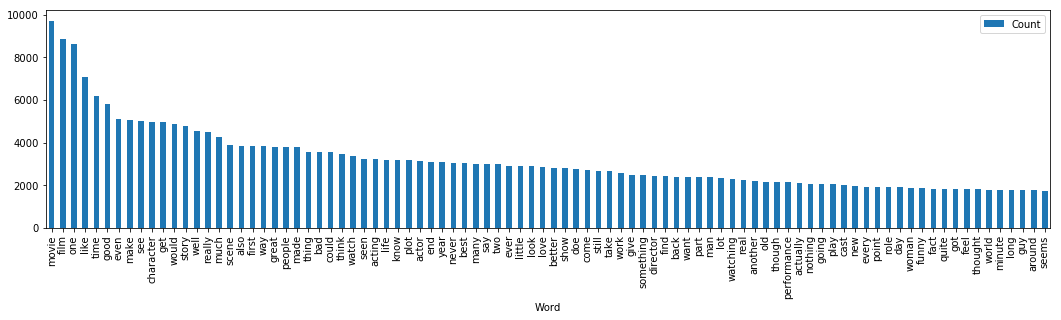

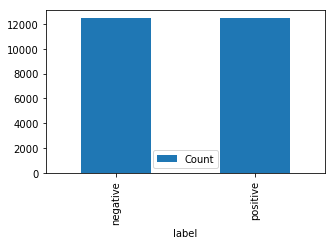

In [12]:
import matplotlib
matplotlib.use('Agg')
import pylab as plt
%matplotlib inline

sentence = x_train['clean_title_text'].tolist()
words = " ".join(sentence).split()
#print(words)
counts = collections.Counter(words).most_common(90)
#lst = word_counter.most_common(n_print)
df = pd.DataFrame(counts, columns = ['Word', 'Count'])
df.plot.bar(x='Word',y='Count',figsize=(18,4))

sentence1 = outData43_lab['label'].tolist()
#print(words)
counts1 = collections.Counter(sentence1).most_common()
#lst = word_counter.most_common(n_print)
df1 = pd.DataFrame(counts1, columns = ['label', 'Count'])
df1.plot.bar(x='label',y='Count',figsize=(5,3))

In [37]:
#print(help(df.plot.bar))

In [38]:
# #!pip install matplotlib
# # sudo apt update
# # sudo apt install libgl1-mesa-glx

# import matplotlib 
# matplotlib.use("tkagg") 
# import matplotlib.pyplot as plt

# wordlist = x_train['clean_title_text'].tolist()
# wordslist = [item.split() for item in wordlist]
# wordslist1 = [item for items in wordslist for item in items]
# #wordslist1[:50]
# fd = nltk.FreqDist(wordslist1)
# fd.plot(30,cumulative=False)

In [13]:
## NB/SVM model
startT = datetime.datetime.now()
pred_labels = []
models=[MultinomialNB(),LinearSVC(),SGDClassifier()]
for model in models:
    clf_nb = Pipeline([('tfidf',TfidfVectorizer(stop_words='english')),('model name',model)])
    clf_nb = clf_nb.fit(x_train.clean_title_text,y_train.label)
    #print(clf_nb.score())
    result = clf_nb.predict(x_test.clean_title_text)
    pred_labels.append(result)
    print('training accuracy score=',np.mean(result==y_test.label))
    print(classification_report(result,y_test.label))
    endT = datetime.datetime.now()
    print("TIME taken for Base Modeling ({} with Tfidf)=".format(model),(endT-startT))

# NB with Tfidf accuracy score= 0.861
# SVC with Tfidf accuracy score= 0.8762
# TIME taken for Base Modeling (NB with tfidf) = 10 min
# TIME taken for Modeling with Tuning (SVC with tfidf) = 30 min

training accuracy score= 0.8556
             precision    recall  f1-score   support

   negative       0.88      0.84      0.86      5194
   positive       0.83      0.88      0.85      4806

avg / total       0.86      0.86      0.86     10000

TIME taken for Base Modeling (MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True) with Tfidf)= 0:00:03.352840
training accuracy score= 0.8786
             precision    recall  f1-score   support

   negative       0.87      0.88      0.88      4908
   positive       0.88      0.88      0.88      5092

avg / total       0.88      0.88      0.88     10000

TIME taken for Base Modeling (LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0) with Tfidf)= 0:00:06.860457
training accuracy score= 0.8847
             precision    recall  f1-score   support

   negative       0.87      0.

In [45]:
## SGDC model
startT = datetime.datetime.now()

clf_sgd = Pipeline([('tfidf',TfidfVectorizer(stop_words='english',use_idf=True)),
                    ('sgd',SGDClassifier(loss='hinge',penalty='l2',alpha=0.0001,n_iter=2))])
clf_sgd = clf_sgd.fit(x_train.clean_title_text,y_train.label)
print("SGDC classifier Tuning")
#print("Training score=",clf_nb.score())
result_sgdctuned = clf_sgd.predict(x_test.clean_title_text)
print('training accuracy score=',np.mean(result_sgdctuned==y_test.label))
print(classification_report(result_sgdctuned,y_test.label))
# print('NB with Tfidf accuracy score=',np.mean(result==y_test.label))
endT = datetime.datetime.now()
print("TIME taken for Modeling with Tuning (SGD with Tfidf)=",(endT-startT))

pred_labels.append(result_sgdctuned)

SGDC classifier Tuning
training accuracy score= 0.8868
             precision    recall  f1-score   support

   negative       0.88      0.89      0.88      2438
   positive       0.89      0.89      0.89      2562

avg / total       0.89      0.89      0.89      5000

TIME taken for Modeling with Tuning (SGD with Tfidf)= 0:00:03.151200


In [46]:
## gridsearhCV (SVC)
startT = datetime.datetime.now()
clf_svc = Pipeline([('tfidf',TfidfVectorizer(stop_words='english')),('svc',LinearSVC(C=10))])

models = [clf_svc]

for model in models:
    params = {'tfidf__ngram_range':[(1,2)],'tfidf__use_idf':[True],
              'tfidf__sublinear_tf':[True],'tfidf__min_df':[1]}
    gs_clf_model = GridSearchCV(model,params,n_jobs=-1)
    gs_clf_model = gs_clf_model.fit(x_train.clean_title_text,y_train.label)
    print("SVC classifier Tuning")
    #print(model.named_steps['svc'])
    print("Trainig score=",gs_clf_model.best_score_)
    print(gs_clf_model.best_params_)

result_svctuned = gs_clf_model.predict(x_test.clean_title_text)
print(classification_report(result_svctuned,y_test.label))
endT = datetime.datetime.now()
print("TIME taken for Modeling with Tuning=",(endT-startT))

pred_labels.append(result_svctuned)

SVC classifier Tuning
Trainig score= 0.8807
{'tfidf__min_df': 1, 'tfidf__ngram_range': (1, 2), 'tfidf__sublinear_tf': True, 'tfidf__use_idf': True}
             precision    recall  f1-score   support

   negative       0.86      0.90      0.88      2338
   positive       0.91      0.87      0.89      2662

avg / total       0.89      0.88      0.88      5000

TIME taken for Modeling with Tuning= 0:00:32.058755


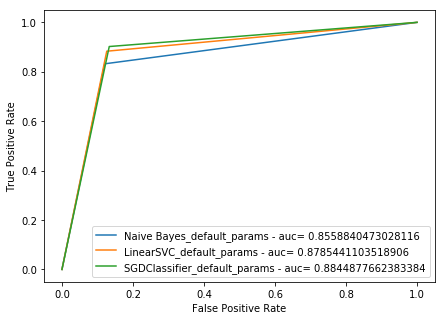

In [14]:
models = ["Naive Bayes_default_params","LinearSVC_default_params","SGDClassifier_default_params"]
#          "SGDClassifier_tuned_params","LinearSVC_tuned_params"]
#pred_labels

from sklearn import metrics
import numpy as np
import matplotlib.pyplot as plt

plt.clf()
plt.figure(figsize=(7,5))

for i in range(len(models)):
    preds = pred_labels[i].tolist()
    pred= [1 if item=='positive' else 0 for item in preds]
    labels = y_test.label.tolist()
    label = [1 if item=='positive' else 0 for item in labels]
    fpr, tpr, thresh = metrics.roc_curve(label, pred)
    auc = metrics.roc_auc_score(label, pred)
    plt.plot(fpr,tpr,label="{} - auc= {}".format(models[i],str(auc)))
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc=0)